# Lab 4. Classification  and regression using KNN and SVM


In [1]:
# Some IPython magic
# Put these at the top of every notebook, here nbagg is used for interactive plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## KNN Classification
KNN is a non-parametric, instance-based, supervised learning algorithm.

It doesn't learn a function, but memorizes the training set, and uses it at inference time.

Pseudocode:

- Train time: store all training points.
- Test time: find the closest k points , and output the most similar class.
### Implement your own knn

Let's say you have the following dataset:

In [2]:
import pickle
data = pickle.load(open('data-knn.pkl', 'rb'))
X = data['data']
y = data['target']

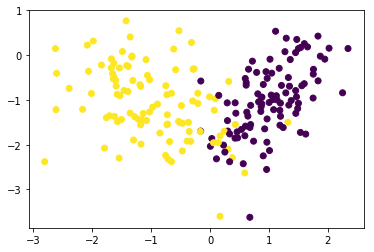

In [3]:
# Plot the dataset. The dataset is 2D.
plt.scatter(X[:,0], X[:,1], c=y)

Implement knn. Implement a function **`pairwise_distance_matrix(X,Y)`** in numpy, that computes the distance between any point in X with any point in Y. Try implementing this function with no for loops.

Hint. You need to use numpy's broadcasting.

In [4]:
# Implement your own euclidean distance method using numpy

def pairwise_distance_matrix(X, Y):
    """Compute the pairwise distance between rows of X and rows of Y
    Arguments
    ----------
    X: ndarray of size (N, D)
    Y: ndarray of size (M, D)
    Returns
    --------
    D: matrix of shape (N, M), each entry D[i,j] is the distance between
    X[i,:] and Y[j,:] using the dot product.
    """
    N, D = X.shape
    M, _ = Y.shape
    U = X.reshape((N,D,1))
    V = Y.T.reshape((1,D,M))
    distance_matrix = np.sqrt(np.sum(((U-V)**2),axis=1))
    return distance_matrix

Now implement KNN such that it takes as input the training dataset. Try to use numpy functions as much as possible.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class myKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self
    
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        # Input validation
        X = check_array(X)
        
        distances = pairwise_distance_matrix(X,self.X_)
        closest_neighbors_idx = np.argpartition(distances, self.n_neighbors)[:,:self.n_neighbors]
        most_common_class = lambda x: np.argmax(np.bincount(x))
        classes = np.apply_along_axis(most_common_class,1,self.y_[closest_neighbors_idx])
        return self.classes_[classes]
    
    def predict_proba(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        # Input validation
        X = check_array(X)
        # Implementing this method is optional
        distances = pairwise_distance_matrix(X,self.X_)
        closest_neighbors_idx = np.argpartition(distances, self.n_neighbors)[:,:self.n_neighbors]
        neighbors = self.y_[closest_neighbors_idx]
        bincount = lambda x: np.bincount(x,minlength=self.n_neighbors)
        frequency = np.apply_along_axis(bincount,1,neighbors)
        return frequency/self.n_neighbors

Test the accuracy of your implementation.

In [6]:
# Partition the data into train and test splits.
# Hint! A good split can be 70% train and 30% test.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Find the accuracy of your KNN implementation
my_knn = myKNN(n_neighbors=3)
my_knn.fit(X_train, y_train)

print(accuracy_score(y_test, my_knn.predict(X_test)))

0.9166666666666666


Now train the sklearn KNN

In [7]:
# Test sklearn's KNN implementation
# Hint! Use algorithm = 'brute' for first try
# Try to improve the score using other parameters for 'metric', 'algorithm' and 'n_neighbors'. 
from sklearn.neighbors import KNeighborsClassifier

# sklearn's knn
skl_knn = KNeighborsClassifier(n_neighbors=3, algorithm = 'brute')
skl_knn.fit(X_train, y_train)
print(skl_knn.score(X_test, y_test))

# my implementation of knn
my_knn = myKNN(n_neighbors=3)
my_knn.fit(X_train, y_train)
print(my_knn.score(X_test, y_test))

0.9166666666666666
0.9166666666666666


## Extra material. Plotting decision boundaries
We will use the plot_decision_boundary function from lab 3, and call it on sklearn's and our implementation of knn.

In [8]:
def plot_decision_boundary(model, X, y):
    """
    Use this to plot the decision boundary of a trained model.
    """
    grid_lim = np.array([[X[:,0].min(), X[:,0].max()], [X[:,1].min(), X[:,1].max()]])
    xx, yy = np.mgrid[grid_lim[0,0]:grid_lim[0,1]:.01, 
                      grid_lim[1,0]:grid_lim[1,1]:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                        vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[:,0], X[:, 1], c=y, s=50,
             cmap="RdBu", vmin=-.2, vmax=1.2,
             edgecolor="white", linewidth=1)

    ax.set(aspect="equal",
           xlim=(grid_lim[0,0],grid_lim[0,1]), 
           ylim=(grid_lim[1,0],grid_lim[1,1]),
           xlabel="$X_1$", ylabel="$X_2$")
    return f, ax

Text(0.5, 1.0, 'KNN implemented here')

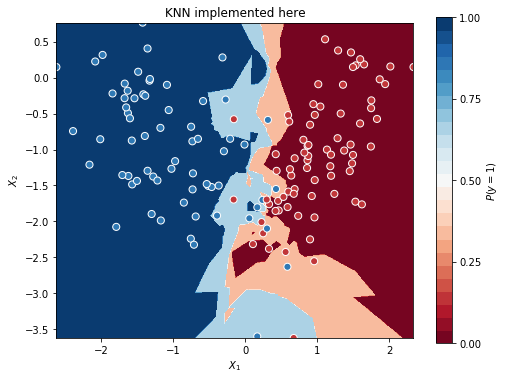

In [9]:
fig, ax = plot_decision_boundary(my_knn,X_train,y_train)
ax.set_title("KNN implemented here")


Text(0.5, 1.0, 'KNN from sklearn')

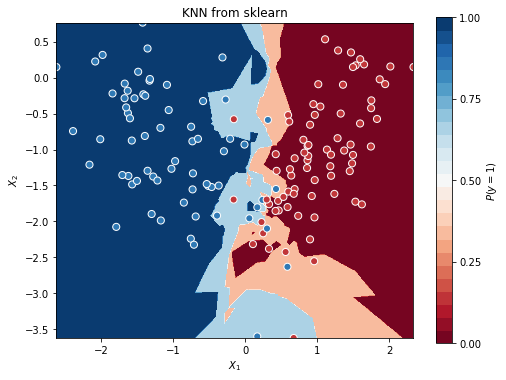

In [10]:
fig, ax = plot_decision_boundary(skl_knn,X_train,y_train)
ax.set_title("KNN from sklearn")

#### Finding the best k
k is a hyperparameter for knn.

A hyperparameter is a parameter that is not learned from the data. In order to find the best hyperparameters you need to train, and measure the validation accuracy for multiple values of the hyperparameters.

(6, 0.95)

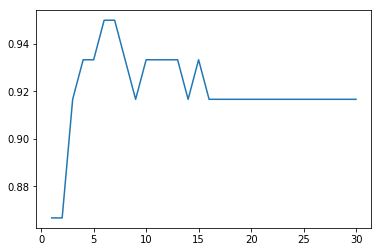

In [11]:
# Implement a method that will find the best K parameter for a classifier.
# Plot every pair of score and K.
# Find best K parameter for the classifier declared before.
def find_best_k(clf, max_k=30):
    scores = []
    for k in range(1,max_k+1):
        clf.n_neighbors = k
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    fig, ax = plt.subplots()
    ax.plot(range(1,max_k+1), scores)
    max_score = max(scores)
    
    return scores.index(max_score) + 1, max_score

find_best_k(my_knn)

Compare the two implementations of knn on the wine dataset. Don't forget to split the dataset into train and test sets.

In [12]:
# Load wine dataset and partition it in train and test splits.
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# sklearn's knn
skl_knn = KNeighborsClassifier(n_neighbors=3, algorithm = 'brute')
skl_knn.fit(X_train, y_train)

# my implementation of knn
my_knn = myKNN(n_neighbors=3)
my_knn.fit(X_train, y_train)

myKNN(n_neighbors=3)

In [13]:
# Test the accuracy of your KNN implementation and sklearn's KNN on wine dataset.

myclf = myKNN(n_neighbors=3)
myclf.fit(X_train, y_train)

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

print("My KNN accuracy: ", myclf.score(X_test, y_test))
print("Sklearn KNN accuracy: ", clf.score(X_test, y_test))

My KNN accuracy:  0.7222222222222222
Sklearn KNN accuracy:  0.7222222222222222


(18, 0.8518518518518519)

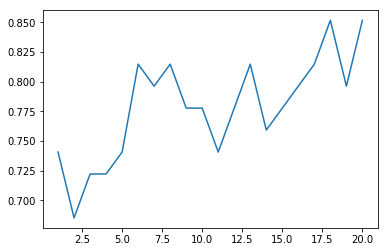

In [14]:
# Find best K parameter for the classifier declared before.
find_best_k(myclf, max_k = 20)

Note that KNN relies on a distance measure. Therefore you need to normalize the data. Try the algorithms again after normalizing the data.

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9259259259259259

(3, 0.9259259259259259)

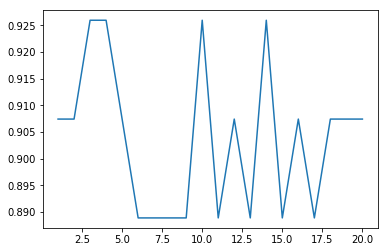

In [16]:
# Find best K parameter for the classifier declared before using scaled data.
find_best_k(clf, max_k = 20)

## SVM Classification

SVM is a classification algorithm that tries to find a separating hyperplane between two classes. It is therefore a linear algorithm. In order to obtain a non-linear separating plane, we can transform the feature space. This can be done using the kernel trick (see lecture slides).

## Extra material. Vizualising feature transformation
Let's say we have data distributed roughly in concentric circles. We can separate the dataset with a circle.

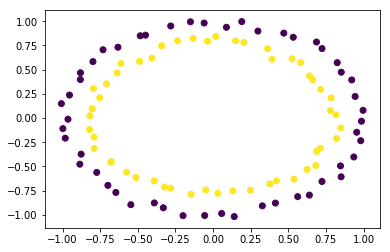

In [17]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.datasets import make_circles
from sklearn.svm import SVC

X,y = make_circles(noise=.025)

ax, fig = plt.subplots()
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()


So we can find a combination of the features that includes the radius. Given features $X_1$ and $X_2$, after normalizing the features to have 0 mean, we have the radius $R = X_1^2 + X_2^2$. In the following plot we represent the features $X_1^2, X_2^2, \sqrt{2} X_1^2 X_2^2$. This corresponds with projecting the dataset on a cone. Alternatively we could also project the dataset on a paraboloid using the features $X_1, X_2, (X_1^2 + X_2^2)$. Change the following code to vizualise the parabolic projection as well.

/home/aniu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


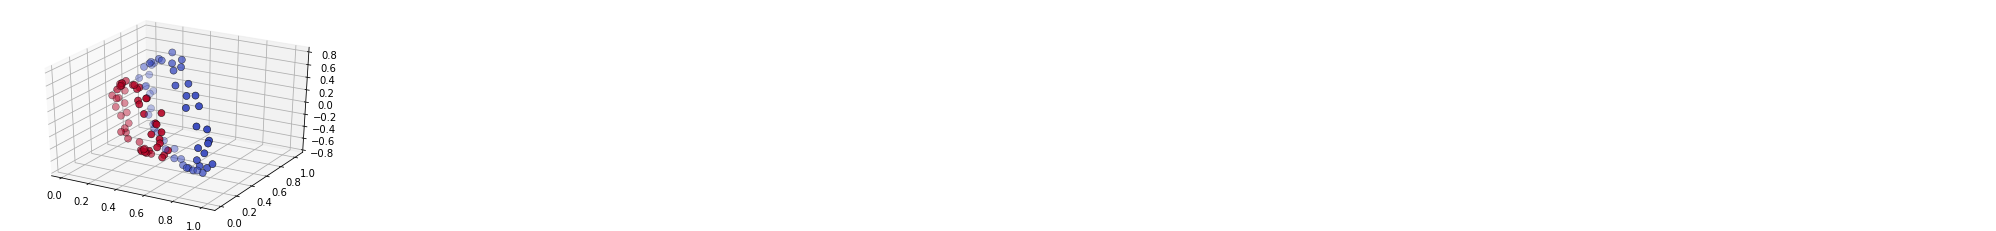

In [18]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
X_ = np.c_[X[:, 0]**2, X[:, 1]**2, X[:,0]*X[:, 1]*np.sqrt(2)]
ax.scatter(X_[:, 0], X_[:, 1], X_[:, 2], c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=0.5)
xx, yy = np.meshgrid(np.linspace(0, 0.5, 2), np.linspace(0, 0.5, 2))
# clf = SVC(kernel='linear').fit(X_, y)
# normal = clf.coef_[0]
# z = (-normal[0] * xx - normal[1] * yy - clf.intercept_) * 1. /normal[2]
# surf = ax.plot_surface(xx, yy, z, alpha=0.5, edgecolor='k', color = 'k')
fig.show()

Now back to SVM

In [19]:
# some datasets that we will use.
from sklearn import datasets
circles = datasets.make_circles(n_samples=200, factor=.5,
                                      noise=.05)
moons = datasets.make_moons(n_samples=200, noise=.05)
blobs = datasets.make_blobs(n_samples=200, random_state=9, centers=2, cluster_std=2)

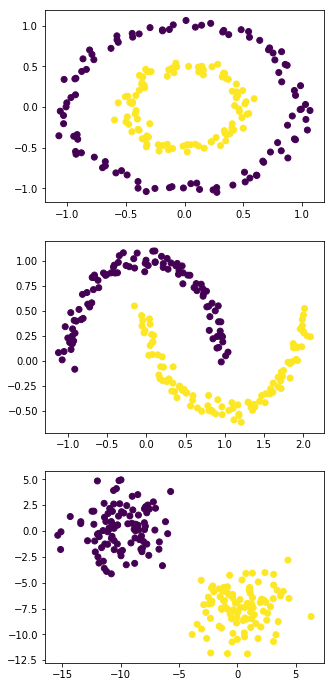

In [20]:
datasets  = [circles, moons, blobs]
fig, axes = plt.subplots(3,1, figsize=(5,12))
for i, (X, y) in enumerate(datasets):
    axes[i].scatter(X[:,0],X[:,1],c=y)
plt.show()

Apply SVM to separate the blobs dataset and plot the decision boundary.

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf40b27470>)

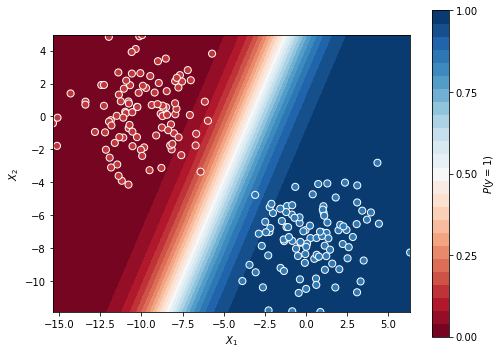

In [21]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', probability=True)
X, y = blobs
clf.fit(X,y)
plot_decision_boundary(clf,X,y)

Now apply SVM on moons and circles datasets. Try different kernels. Which one works best?

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf40b5d1d0>)

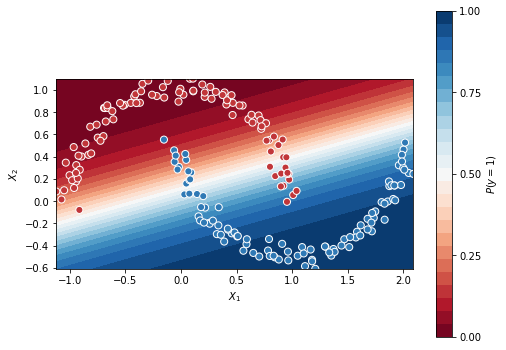

In [22]:

clf = SVC(kernel='linear', probability=True)
X, y = moons
clf.fit(X,y)
plot_decision_boundary(clf,X,y)

/home/aniu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf4010db00>)

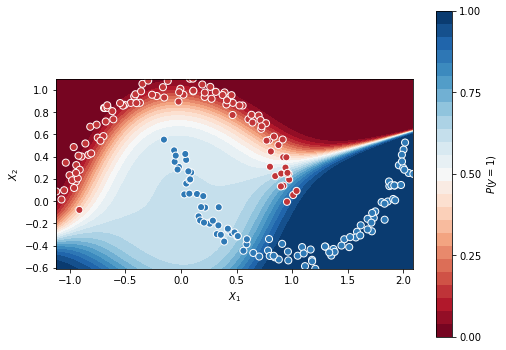

In [23]:
clf = SVC(kernel='poly', degree=5, probability=True)
X, y = moons
clf.fit(X,y)
plot_decision_boundary(clf,X,y)

/home/aniu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf400352b0>)

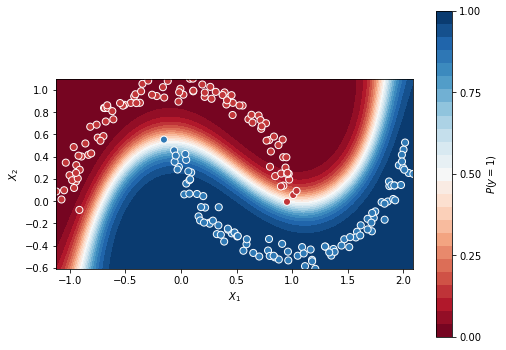

In [24]:
clf = SVC(kernel='rbf', probability=True)
X, y = moons
clf.fit(X,y)
plot_decision_boundary(clf,X,y)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf40075e48>)

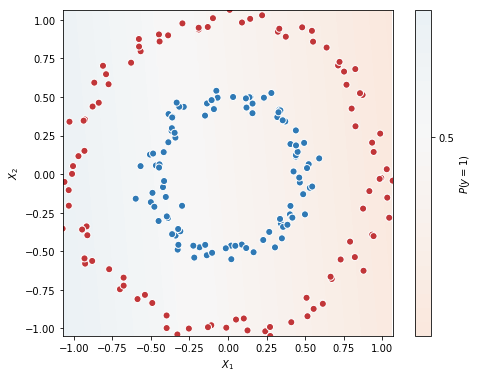

In [25]:
clf = SVC(kernel='linear', probability=True)
X, y = circles
clf.fit(X,y)
plot_decision_boundary(clf,X,y)

/home/aniu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf2af257f0>)

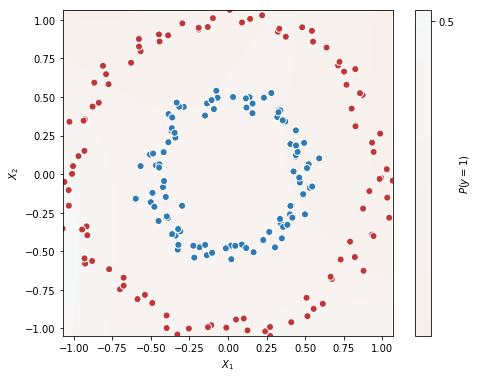

In [26]:
clf = SVC(kernel='poly',  probability=True)
X, y = circles
clf.fit(X,y)
plot_decision_boundary(clf,X,y)

/home/aniu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf2ad92e10>)

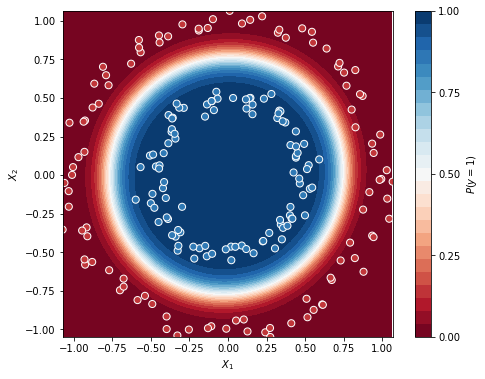

In [27]:
clf = SVC(kernel='rbf', probability=True)
X, y = circles
clf.fit(X,y)
plot_decision_boundary(clf,X,y)

RBF kernel works well for both circles and moons datasets.

### Hyperparameter tuning
What if we had non-separable data? We need to find the best kernel with the best hyperparameters. We need to set up an experiment, split the dataset into train and test set, measure accuracy on test set to evaluate performance, and tune the hyperparameters to find the model that works best. 

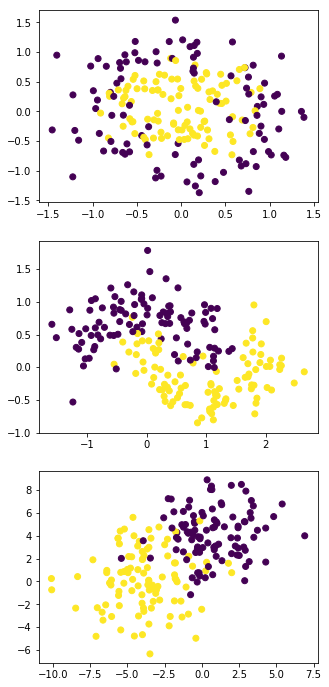

In [28]:
from sklearn import datasets
circles = datasets.make_circles(n_samples=200, factor=.5,
                                      noise=.25)
moons = datasets.make_moons(n_samples=200, noise=.25)
blobs = datasets.make_blobs(n_samples=200, random_state=3, centers=2, cluster_std=2.2)
datasets  = [circles, moons, blobs]
fig, axes = plt.subplots(3,1, figsize=(5,12))
for i, (X, y) in enumerate(datasets):
    axes[i].scatter(X[:,0],X[:,1],c=y)
plt.show()

#### Grid search
In order to tune a hyperparameter you should set up a validation experiment, and loop over different values of that hyperparameter, calling the experiment to train, test, score the model. If there are more hyperparameters, you could use nested loops. However, sklearn provides a tool to tune those parameters called [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Use grid search to find the best parameters for the 3 datasets (circles, moons and blobs).

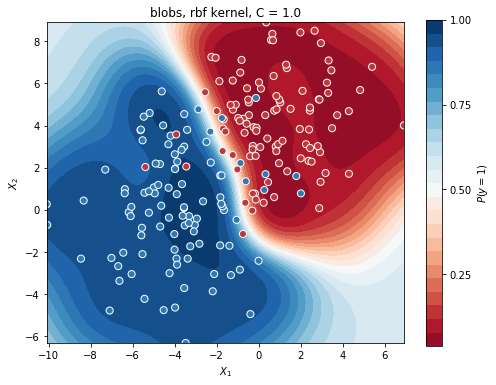

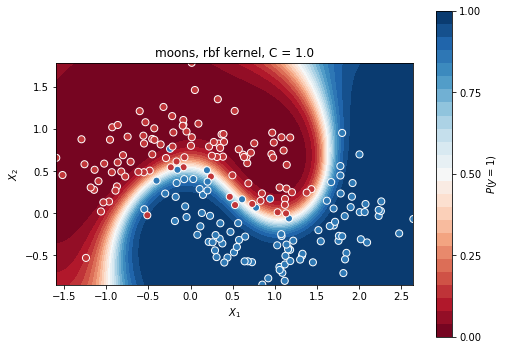

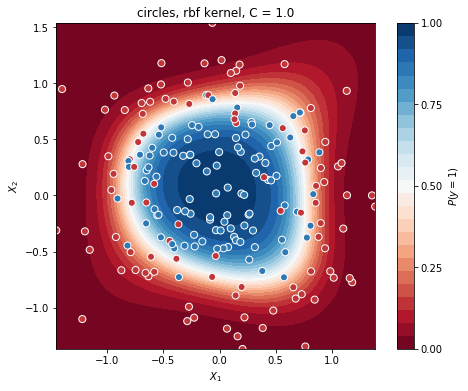

In [30]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# feel free to add more parameters, but keep in mind that 
# training multiple models might be very computationaly expensive.
parameters = [{'kernel':('linear','rbf'), 'C':[0.01, 0.1, 1, 10] },
              {'kernel':('poly',), 'C':[0.01, 0.1, 1, 10], 'degree':[3,4,5] }
             ]
dataset_names = ['blobs', 'moons', 'circles']
for ((X, y), name) in zip([blobs, moons, circles], dataset_names):
    svc = svm.SVC(gamma="scale", probability=True)
    clf = GridSearchCV(svc, parameters, cv=5)
    clf.fit(X, y)
    fig, ax = plot_decision_boundary(clf,X,y)
    ax.set_title("{}, {} kernel, C = {}".format(name, 
                                        clf.get_params()['estimator__kernel'],
                                        clf.get_params()['estimator__C']))
    

## Regression
Both KNN and SVM can be adapted to be applied on regression problems. Both algorithms rely on distance metrics, therefore make sure you normalize your dataset. You can research different normalization techniques [here](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).


In [ ]:
# Apply KNN regression and SVM regression on the following dataset
# SVM regression

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

dataset = fetch_california_housing()
X, y = dataset.data, dataset.target
X_scaled = StandardScaler().fit_transform(X)

# feel free to add more parameters, but keep in mind that 
# training multiple models might be very computationaly expensive.
parameters = [{'kernel':('linear', 'rbf'), 
               'C':[0.1, 1, 10], 'epsilon':[0.01, 0.1, 1] },
              {'kernel':('poly',), 'C':[0.1, 1, 10], 'degree':[3,5],
                  'epsilon':[0.1, 1] }
             ]
svr = svm.SVR(gamma="scale")
clf = GridSearchCV(svr, parameters, cv=5)
clf.fit(X_scaled, y)
print(clf.get_params())

In [ ]:
# KNN regression

from sklearn.neighbors import KNeighborsRegressor
parameters = {'n_neighbors': [2, 3, 4, 5, 7] },
knr = KNeighborsRegressor()
clf = GridSearchCV(knr, parameters, cv=5)
clf.fit(X_scaled, y)
print(clf.get_params())